<a href="https://colab.research.google.com/github/ykitaguchi77/statistics_for_articles/blob/main/GravAI_treatment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**GravAI Before-After study**

In [2]:
# prompt: gdrive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import pandas as pd
from scipy.stats import mannwhitneyu
import numpy as np

def run_robust_statistical_analysis(file_path):
    """
    より堅牢なデータ処理方法で統計解析を実行する。
    """
    # ===============================================================
    # Step 1: データの読み込みと前処理
    # ===============================================================
    print(f"ファイル '{file_path}' を読み込んでいます...")
    df = pd.read_excel(file_path)

    # フィルター条件は提供されたコードに合わせて一旦コメントアウト
    # df_filtered = df[(df['steroid pulse'] != 0) & (df['operation'] == '-')].copy()
    df_clean = df.copy()

    # --- 安全なデータ抽出関数 ---
    def safe_parse_eye_values(df_to_parse, column_name):
        right_eye_data, left_eye_data = {}, {}
        for idx, value in df_to_parse[column_name].dropna().items():
            if not isinstance(value, str): continue
            parts = value.replace(' ', '').split(',')
            if len(parts) == 2:
                try:
                    right_eye_data[idx] = float(parts[0])
                    left_eye_data[idx] = float(parts[1])
                except (ValueError, TypeError): continue
        s_right = pd.Series(right_eye_data, name=f'{column_name}_R').reindex(df_to_parse.index)
        s_left = pd.Series(left_eye_data, name=f'{column_name}_L').reindex(df_to_parse.index)
        return s_right, s_left

    # --- 全ての列を最初にクリーニング ---
    print("データをクリーニングし、計算用の列を準備しています...")
    # 眼関連の列を抽出し、左右の列を生成
    eye_cols = ['MRD-1_pre', 'MRD1_post', 'MRD-2_pre', 'MRD2_post', 'Hertel_pre', 'Hertel_post']
    for col in eye_cols:
        if col in df_clean.columns:
            s_right, s_left = safe_parse_eye_values(df_clean, col)
            df_clean[s_right.name] = s_right
            df_clean[s_left.name] = s_left

    # 非眼関連の列を安全に数値化
    non_eye_cols = ['Gorman score_pre', 'Gorman score_post', 'CAS_pre', 'CAS_post']
    for col in non_eye_cols:
        if col in df_clean.columns:
            df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

    # --- 正しい方法でΔ（変化量）を計算 ---
    # 患者ごと（行ごと）に計算し、ペアがなければNaNになる
    delta_definitions = {
        'ΔMRD-1': ('MRD-1_pre', 'MRD1_post'),
        'ΔMRD-2': ('MRD-2_pre', 'MRD2_post'),
        'ΔHertel': ('Hertel_pre', 'Hertel_post'),
    }
    for delta_name, (pre_name, post_name) in delta_definitions.items():
        # post_nameのハイフンを削除 (例: MRD1_post)
        post_name_clean = post_name.replace('-', '')
        if f'{pre_name}_R' in df_clean.columns and f'{post_name_clean}_R' in df_clean.columns:
            df_clean[f'{delta_name}_R'] = df_clean[f'{post_name_clean}_R'] - df_clean[f'{pre_name}_R']
            df_clean[f'{delta_name}_L'] = df_clean[f'{post_name_clean}_L'] - df_clean[f'{pre_name}_L']

    # 非眼関連のΔを計算
    if 'Gorman score_pre' in df_clean.columns and 'Gorman score_post' in df_clean.columns:
        df_clean['ΔGorman score'] = df_clean['Gorman score_post'] - df_clean['Gorman score_pre']
    if 'CAS_pre' in df_clean.columns and 'CAS_post' in df_clean.columns:
        df_clean['ΔCAS'] = df_clean['CAS_post'] - df_clean['CAS_pre']

    # ===============================================================
    # Step 2: 統計解析の実行
    # ===============================================================
    print("統計解析を実行しています...")

    # --- ヘルパー関数 (再利用) ---
    def descriptive_stats(series):
        series_clean = series.dropna()
        if len(series_clean) == 0:
            return {'Min': None, 'Q1': None, 'Median': None, 'Q3': None, 'Max': None, 'Mean': None, 'SD': None, 'Count': 0}
        return {'Min': series_clean.min(), 'Q1': series_clean.quantile(0.25), 'Median': series_clean.median(),
                'Q3': series_clean.quantile(0.75), 'Max': series_clean.max(), 'Mean': series_clean.mean(),
                'SD': series_clean.std(), 'Count': len(series_clean)}

    def mann_whitney_test(group1, group2):
        g1_clean, g2_clean = group1.dropna(), group2.dropna()
        if len(g1_clean) > 0 and len(g2_clean) > 0:
            return mannwhitneyu(g1_clean, g2_clean, alternative='two-sided')
        return None, None

    # --- 解析の準備 ---
    results = []
    # 解析対象の変数を定義
    variables_to_analyze = [
        'MRD-1_pre_R', 'MRD-1_pre_L', 'MRD1_post_R', 'MRD1_post_L', 'ΔMRD-1_R', 'ΔMRD-1_L',
        'MRD-2_pre_R', 'MRD-2_pre_L', 'MRD2_post_R', 'MRD2_post_L', 'ΔMRD-2_R', 'ΔMRD-2_L',
        'Hertel_pre_R', 'Hertel_pre_L', 'Hertel_post_R', 'Hertel_post_L', 'ΔHertel_R', 'ΔHertel_L',
        'Gorman score_pre', 'Gorman score_post', 'ΔGorman score',
        'CAS_pre', 'CAS_post', 'ΔCAS'
    ]

    # 2つのグループを定義
    group1_df = df_clean[df_clean['difference'] <= -30]
    group2_df = df_clean[df_clean['difference'] > -30]
    print(f"\ndifference ≤ -30群: {len(group1_df)}件")
    print(f"difference > -30群: {len(group2_df)}件")

    # --- ループによる解析実行 ---
    for var in variables_to_analyze:
        if var not in df_clean.columns: continue

        # データを抽出
        g1_series = group1_df[var]
        g2_series = group2_df[var]

        # Mann-Whitney U検定
        stat, p_value = mann_whitney_test(g1_series, g2_series)

        # 結果の整形
        # Variable名から _R, _L を取り除く
        var_name = var.replace('_R', '').replace('_L', '')
        eye_type = 'Right' if var.endswith('_R') else 'Left' if var.endswith('_L') else 'Both'

        # 結果をリストに追加
        for group_name, series in [('difference ≤ -30', g1_series), ('difference > -30', g2_series)]:
            stats = descriptive_stats(series)
            results.append({'Variable': var_name, 'Eye': eye_type, 'Group': group_name, 'Statistic': stat, 'P-value': p_value, **stats})

    # Bilateral (両眼) のデータを追加
    bilateral_vars = [v for v in variables_to_analyze if v.endswith('_R')]
    for var_r in bilateral_vars:
        var_l = var_r.replace('_R', '_L')
        if var_l in df_clean.columns:
            # 両眼のデータを作成
            g1_bilateral = pd.concat([group1_df[var_r], group1_df[var_l]], ignore_index=True)
            g2_bilateral = pd.concat([group2_df[var_r], group2_df[var_l]], ignore_index=True)

            stat, p_value = mann_whitney_test(g1_bilateral, g2_bilateral)
            var_name = var_r.replace('_R', '')

            for group_name, series in [('difference ≤ -30', g1_bilateral), ('difference > -30', g2_bilateral)]:
                stats = descriptive_stats(series)
                results.append({'Variable': var_name, 'Eye': 'Bilateral', 'Group': group_name, 'Statistic': stat, 'P-value': p_value, **stats})

    # ===============================================================
    # Step 3: 結果の出力
    # ===============================================================
    print("\n===== 統計分析結果 =====")
    results_df = pd.DataFrame(results)

    # 表示形式を整える
    pd.options.display.float_format = '{:.4f}'.format

    # Significance列を追加
    results_df['Significance'] = np.where(results_df['P-value'] < 0.05, 'Significant', 'Not Significant')
    print(results_df)

    # Excelに保存
    output_filename = 'statistical_analysis_results_robust.xlsx'
    results_df.to_excel(output_filename, index=False)
    print(f"\nExcelファイル '{output_filename}' に結果を保存しました。")

    # ===== Mean±SD形式の結果を出力 =====
    print("\n===== Mean±SD形式の結果 =====")
    # pivot_tableでデータを整形
    summary_table = results_df.pivot_table(
        index=['Variable', 'Eye'],
        columns='Group',
        values=['Mean', 'SD', 'Count', 'P-value']
    ).reset_index()

    # 表示
    for index, row in summary_table.iterrows():
        var, eye = row[('Variable', '')], row[('Eye', '')]
        mean1, sd1, n1 = row[('Mean', 'difference ≤ -30')], row[('SD', 'difference ≤ -30')], row[('Count', 'difference ≤ -30')]
        mean2, sd2, n2 = row[('Mean', 'difference > -30')], row[('SD', 'difference > -30')], row[('Count', 'difference > -30')]
        p_val = row[('P-value', 'difference ≤ -30')] # p-valueはどちらのグループも同じ

        # データが存在する場合のみ表示
        if pd.notna(mean1) and pd.notna(mean2):
            print(f"\n----- {var} ({eye}) -----")
            print(f"  ≤ -30群: {mean1:.2f} ± {sd1:.2f} (n={int(n1)})")
            print(f"  > -30群: {mean2:.2f} ± {sd2:.2f} (n={int(n2)})")
            print(f"  p値: {p_val:.4f} {'(有意差あり)' if p_val < 0.05 else ''}")

    # ===== 有意差のある項目を最後にまとめる =====
    significant_results = results_df[
        (results_df['P-value'] < 0.05) &
        (results_df['Group'] == 'difference ≤ -30') # 重複を避けるため片方の群のみ選択
    ].sort_values('P-value')

    if not significant_results.empty:
        print("\n===== 有意差のある項目 (p<0.05) =====")
        print(significant_results[['Variable', 'Eye', 'P-value']])
    else:
        print("\n有意差のある項目はありませんでした。")

    return results_df

# ===============================================================
# 実行ブロック
# ===============================================================
# ファイルパスを正確に設定してください
#file_path = "/content/drive/MyDrive/発表/2025日本眼科AI学会/patientlist'_20250612.xlsx"
file_path = "/content/drive/MyDrive/発表/2025日本眼科AI学会/patientlist'.xlsx"

# 関数を実行
final_results = run_robust_statistical_analysis(file_path)

ファイル '/content/drive/MyDrive/発表/2025日本眼科AI学会/patientlist'.xlsx' を読み込んでいます...
データをクリーニングし、計算用の列を準備しています...
統計解析を実行しています...

difference ≤ -30群: 12件
difference > -30群: 30件

===== 統計分析結果 =====
       Variable        Eye             Group  Statistic  P-value     Min  \
0     MRD-1_pre      Right  difference ≤ -30   213.5000   0.3544  2.5000   
1     MRD-1_pre      Right  difference > -30   213.5000   0.3544  2.0000   
2     MRD-1_pre       Left  difference ≤ -30   131.0000   0.1729  2.5000   
3     MRD-1_pre       Left  difference > -30   131.0000   0.1729  2.5000   
4     MRD1_post      Right  difference ≤ -30   117.5000   0.0823  2.5000   
..          ...        ...               ...        ...      ...     ...   
61   Hertel_pre  Bilateral  difference > -30   514.0000   0.8630 12.0000   
62  Hertel_post  Bilateral  difference ≤ -30   293.0000   0.0191 11.0000   
63  Hertel_post  Bilateral  difference > -30   293.0000   0.0191 10.0000   
64      ΔHertel  Bilateral  difference ≤ -30   316.

In [ ]:
### ステロイドパルスのみ群のみをフィルタリング

import pandas as pd
from scipy.stats import mannwhitneyu
import numpy as np

def run_robust_statistical_analysis(file_path):
    """
    より堅牢なデータ処理方法で統計解析を実行する。
    """
    # ===============================================================
    # Step 1: データの読み込みと前処理
    # ===============================================================
    print(f"ファイル '{file_path}' を読み込んでいます...")
    df = pd.read_excel(file_path)

    # フィルター条件は提供されたコードに合わせて一旦コメントアウト
    df_clean = df[(df['steroid pulse'] != 0) & (df['operation'] == '-')].copy()
    #df_clean = df.copy()

    # --- 安全なデータ抽出関数 ---
    def safe_parse_eye_values(df_to_parse, column_name):
        right_eye_data, left_eye_data = {}, {}
        for idx, value in df_to_parse[column_name].dropna().items():
            if not isinstance(value, str): continue
            parts = value.replace(' ', '').split(',')
            if len(parts) == 2:
                try:
                    right_eye_data[idx] = float(parts[0])
                    left_eye_data[idx] = float(parts[1])
                except (ValueError, TypeError): continue
        s_right = pd.Series(right_eye_data, name=f'{column_name}_R').reindex(df_to_parse.index)
        s_left = pd.Series(left_eye_data, name=f'{column_name}_L').reindex(df_to_parse.index)
        return s_right, s_left

    # --- 全ての列を最初にクリーニング ---
    print("データをクリーニングし、計算用の列を準備しています...")
    # 眼関連の列を抽出し、左右の列を生成
    eye_cols = ['MRD-1_pre', 'MRD1_post', 'MRD-2_pre', 'MRD2_post', 'Hertel_pre', 'Hertel_post']
    for col in eye_cols:
        if col in df_clean.columns:
            s_right, s_left = safe_parse_eye_values(df_clean, col)
            df_clean[s_right.name] = s_right
            df_clean[s_left.name] = s_left

    # 非眼関連の列を安全に数値化
    non_eye_cols = ['Gorman score_pre', 'Gorman score_post', 'CAS_pre', 'CAS_post']
    for col in non_eye_cols:
        if col in df_clean.columns:
            df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

    # --- 正しい方法でΔ（変化量）を計算 ---
    # 患者ごと（行ごと）に計算し、ペアがなければNaNになる
    delta_definitions = {
        'ΔMRD-1': ('MRD-1_pre', 'MRD1_post'),
        'ΔMRD-2': ('MRD-2_pre', 'MRD2_post'),
        'ΔHertel': ('Hertel_pre', 'Hertel_post'),
    }
    for delta_name, (pre_name, post_name) in delta_definitions.items():
        # post_nameのハイフンを削除 (例: MRD1_post)
        post_name_clean = post_name.replace('-', '')
        if f'{pre_name}_R' in df_clean.columns and f'{post_name_clean}_R' in df_clean.columns:
            df_clean[f'{delta_name}_R'] = df_clean[f'{post_name_clean}_R'] - df_clean[f'{pre_name}_R']
            df_clean[f'{delta_name}_L'] = df_clean[f'{post_name_clean}_L'] - df_clean[f'{pre_name}_L']

    # 非眼関連のΔを計算
    if 'Gorman score_pre' in df_clean.columns and 'Gorman score_post' in df_clean.columns:
        df_clean['ΔGorman score'] = df_clean['Gorman score_post'] - df_clean['Gorman score_pre']
    if 'CAS_pre' in df_clean.columns and 'CAS_post' in df_clean.columns:
        df_clean['ΔCAS'] = df_clean['CAS_post'] - df_clean['CAS_pre']

    # ===============================================================
    # Step 2: 統計解析の実行
    # ===============================================================
    print("統計解析を実行しています...")

    # --- ヘルパー関数 (再利用) ---
    def descriptive_stats(series):
        series_clean = series.dropna()
        if len(series_clean) == 0:
            return {'Min': None, 'Q1': None, 'Median': None, 'Q3': None, 'Max': None, 'Mean': None, 'SD': None, 'Count': 0}
        return {'Min': series_clean.min(), 'Q1': series_clean.quantile(0.25), 'Median': series_clean.median(),
                'Q3': series_clean.quantile(0.75), 'Max': series_clean.max(), 'Mean': series_clean.mean(),
                'SD': series_clean.std(), 'Count': len(series_clean)}

    def mann_whitney_test(group1, group2):
        g1_clean, g2_clean = group1.dropna(), group2.dropna()
        if len(g1_clean) > 0 and len(g2_clean) > 0:
            return mannwhitneyu(g1_clean, g2_clean, alternative='two-sided')
        return None, None

    # --- 解析の準備 ---
    results = []
    # 解析対象の変数を定義
    variables_to_analyze = [
        'MRD-1_pre_R', 'MRD-1_pre_L', 'MRD1_post_R', 'MRD1_post_L', 'ΔMRD-1_R', 'ΔMRD-1_L',
        'MRD-2_pre_R', 'MRD-2_pre_L', 'MRD2_post_R', 'MRD2_post_L', 'ΔMRD-2_R', 'ΔMRD-2_L',
        'Hertel_pre_R', 'Hertel_pre_L', 'Hertel_post_R', 'Hertel_post_L', 'ΔHertel_R', 'ΔHertel_L',
        'Gorman score_pre', 'Gorman score_post', 'ΔGorman score',
        'CAS_pre', 'CAS_post', 'ΔCAS'
    ]

    # 2つのグループを定義
    group1_df = df_clean[df_clean['difference'] <= -30]
    group2_df = df_clean[df_clean['difference'] > -30]
    print(f"\ndifference ≤ -30群: {len(group1_df)}件")
    print(f"difference > -30群: {len(group2_df)}件")

    # --- ループによる解析実行 ---
    for var in variables_to_analyze:
        if var not in df_clean.columns: continue

        # データを抽出
        g1_series = group1_df[var]
        g2_series = group2_df[var]

        # Mann-Whitney U検定
        stat, p_value = mann_whitney_test(g1_series, g2_series)

        # 結果の整形
        # Variable名から _R, _L を取り除く
        var_name = var.replace('_R', '').replace('_L', '')
        eye_type = 'Right' if var.endswith('_R') else 'Left' if var.endswith('_L') else 'Both'

        # 結果をリストに追加
        for group_name, series in [('difference ≤ -30', g1_series), ('difference > -30', g2_series)]:
            stats = descriptive_stats(series)
            results.append({'Variable': var_name, 'Eye': eye_type, 'Group': group_name, 'Statistic': stat, 'P-value': p_value, **stats})

    # Bilateral (両眼) のデータを追加
    bilateral_vars = [v for v in variables_to_analyze if v.endswith('_R')]
    for var_r in bilateral_vars:
        var_l = var_r.replace('_R', '_L')
        if var_l in df_clean.columns:
            # 両眼のデータを作成
            g1_bilateral = pd.concat([group1_df[var_r], group1_df[var_l]], ignore_index=True)
            g2_bilateral = pd.concat([group2_df[var_r], group2_df[var_l]], ignore_index=True)

            stat, p_value = mann_whitney_test(g1_bilateral, g2_bilateral)
            var_name = var_r.replace('_R', '')

            for group_name, series in [('difference ≤ -30', g1_bilateral), ('difference > -30', g2_bilateral)]:
                stats = descriptive_stats(series)
                results.append({'Variable': var_name, 'Eye': 'Bilateral', 'Group': group_name, 'Statistic': stat, 'P-value': p_value, **stats})

    # ===============================================================
    # Step 3: 結果の出力
    # ===============================================================
    print("\n===== 統計分析結果 =====")
    results_df = pd.DataFrame(results)

    # 表示形式を整える
    pd.options.display.float_format = '{:.4f}'.format

    # Significance列を追加
    results_df['Significance'] = np.where(results_df['P-value'] < 0.05, 'Significant', 'Not Significant')
    print(results_df)

    # Excelに保存
    output_filename = 'statistical_analysis_results_robust.xlsx'
    results_df.to_excel(output_filename, index=False)
    print(f"\nExcelファイル '{output_filename}' に結果を保存しました。")

    # ===== Mean±SD形式の結果を出力 =====
    print("\n===== Mean±SD形式の結果 =====")
    # pivot_tableでデータを整形
    summary_table = results_df.pivot_table(
        index=['Variable', 'Eye'],
        columns='Group',
        values=['Mean', 'SD', 'Count', 'P-value']
    ).reset_index()

    # 表示
    for index, row in summary_table.iterrows():
        var, eye = row[('Variable', '')], row[('Eye', '')]
        mean1, sd1, n1 = row[('Mean', 'difference ≤ -30')], row[('SD', 'difference ≤ -30')], row[('Count', 'difference ≤ -30')]
        mean2, sd2, n2 = row[('Mean', 'difference > -30')], row[('SD', 'difference > -30')], row[('Count', 'difference > -30')]
        p_val = row[('P-value', 'difference ≤ -30')] # p-valueはどちらのグループも同じ

        # データが存在する場合のみ表示
        if pd.notna(mean1) and pd.notna(mean2):
            print(f"\n----- {var} ({eye}) -----")
            print(f"  ≤ -30群: {mean1:.2f} ± {sd1:.2f} (n={int(n1)})")
            print(f"  > -30群: {mean2:.2f} ± {sd2:.2f} (n={int(n2)})")
            print(f"  p値: {p_val:.4f} {'(有意差あり)' if p_val < 0.05 else ''}")

    # ===== 有意差のある項目を最後にまとめる =====
    significant_results = results_df[
        (results_df['P-value'] < 0.05) &
        (results_df['Group'] == 'difference ≤ -30') # 重複を避けるため片方の群のみ選択
    ].sort_values('P-value')

    if not significant_results.empty:
        print("\n===== 有意差のある項目 (p<0.05) =====")
        print(significant_results[['Variable', 'Eye', 'P-value']])
    else:
        print("\n有意差のある項目はありませんでした。")

    return results_df

# ===============================================================
# 実行ブロック
# ===============================================================
# ファイルパスを正確に設定してください
file_path = "/content/drive/MyDrive/発表/2025日本眼科AI学会/patientlist'_20250612.xlsx"

# 関数を実行
final_results = run_robust_statistical_analysis(file_path)

データ前処理を開始します...
データ前処理が完了しました。

最終版グラフが 'poster_layout_final.png' として保存されました。


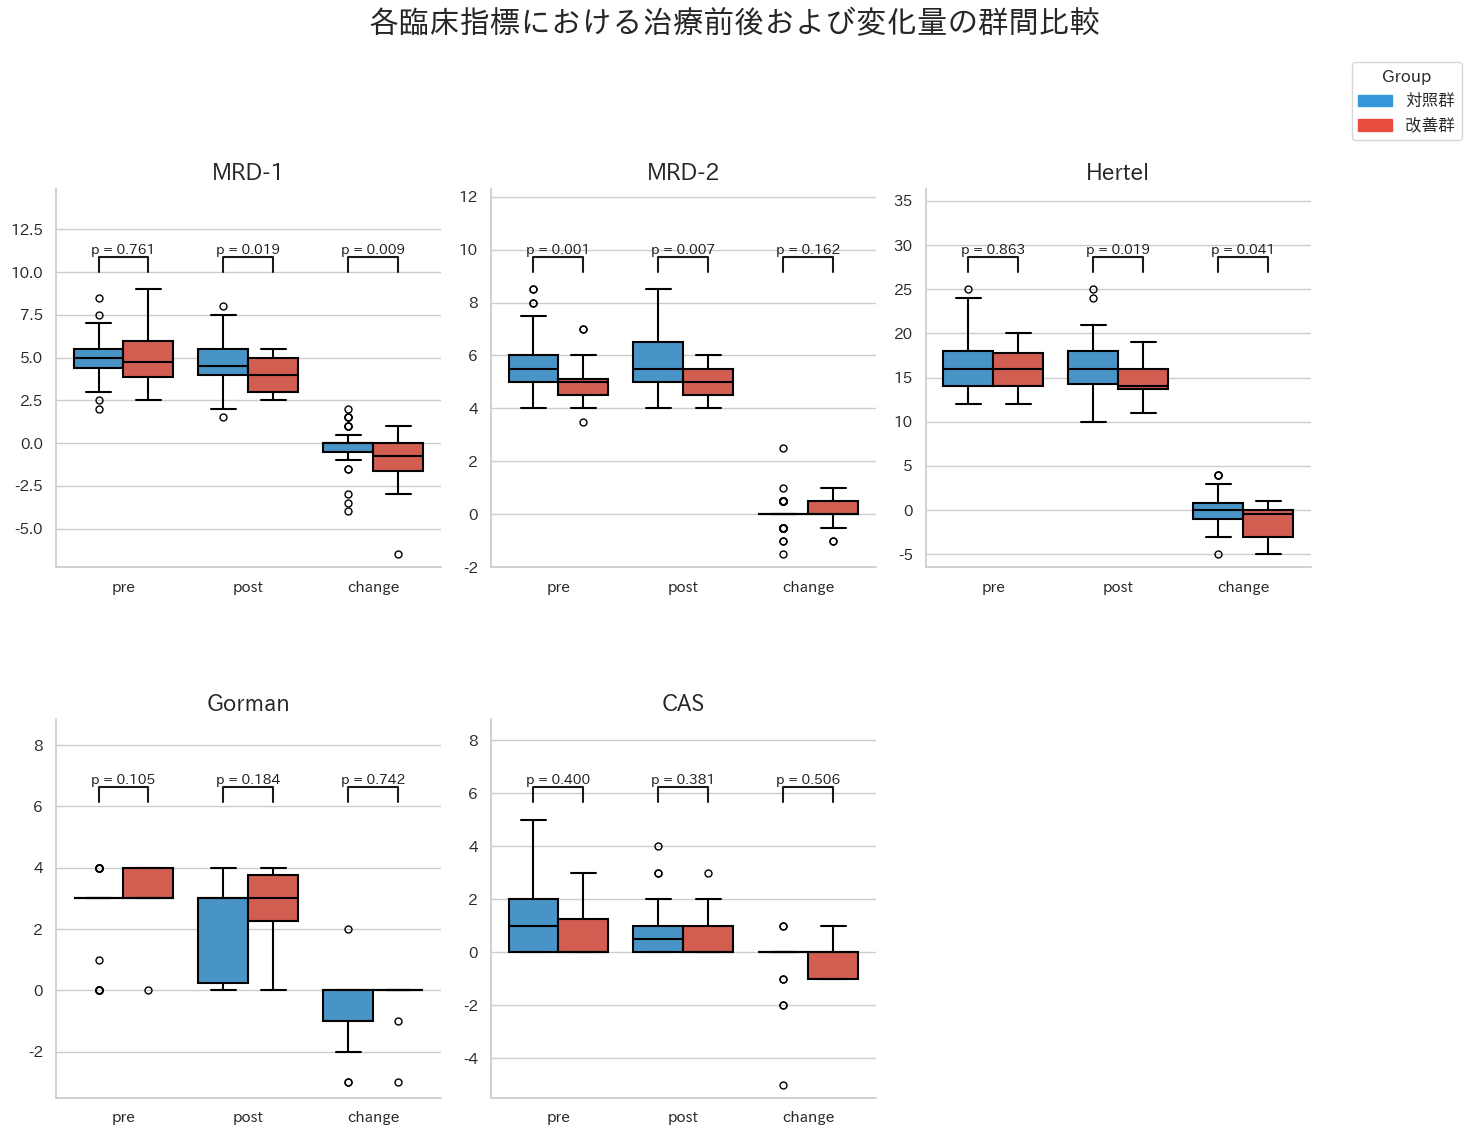

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np
import os
from scipy.stats import mannwhitneyu

# ===============================================================
# 1. 日本語フォント設定
# ===============================================================
# !apt-get -y install fonts-ipafont-gothic > /dev/null
# !pip install japanize-matplotlib > /dev/null
import japanize_matplotlib
plt.rcParams['font.sans-serif'] = ['IPAexGothic']
plt.rcParams['axes.unicode_minus'] = False
sns.set_theme(style="whitegrid", font='IPAexGothic')

# ===============================================================
# 2. データ前処理とグラフ描画用の関数
# ===============================================================

def create_tidy_dataframe(file_path):
    """グラフ作成に適した「Tidy Data」形式のDataFrameを作成する"""
    print("データ前処理を開始します...")
    df = pd.read_excel(file_path)
    df_clean = df.copy()
    df_clean['Group'] = np.where(df_clean['difference'] <= -30, '改善群', '対照群')
    df_clean.reset_index(inplace=True, names='PatientID')

    all_rows = []
    metrics = {
        'MRD-1': ('MRD-1_pre', 'MRD1_post'), 'MRD-2': ('MRD-2_pre', 'MRD2_post'),
        'Hertel': ('Hertel_pre', 'Hertel_post'), 'Gorman': ('Gorman score_pre', 'Gorman score_post'),
        'CAS': ('CAS_pre', 'CAS_post')
    }

    for metric_name, (pre_col, post_col) in metrics.items():
        is_eye_metric = metric_name in ['MRD-1', 'MRD-2', 'Hertel']

        if is_eye_metric:
            pre_r, pre_l = safe_parse_eye_values(df_clean, pre_col)
            post_r, post_l = safe_parse_eye_values(df_clean, post_col.replace('-', ''))
            pre_vals = pd.concat([pre_r, pre_l], ignore_index=False)
            post_vals = pd.concat([post_r, post_l], ignore_index=False)
        else:
            pre_vals = pd.to_numeric(df_clean[pre_col], errors='coerce')
            post_vals = pd.to_numeric(df_clean[post_col], errors='coerce')

        delta_vals = post_vals - pre_vals

        for time_point, data_series in [('pre', pre_vals), ('post', post_vals), ('change', delta_vals)]:
            temp_df = data_series.dropna().to_frame(name='Value')
            temp_df = temp_df.join(df_clean[['PatientID', 'Group']])
            temp_df['Metric'] = metric_name
            temp_df['Time'] = time_point
            all_rows.append(temp_df)

    tidy_df = pd.concat(all_rows, ignore_index=True)
    print("データ前処理が完了しました。")
    return tidy_df

def finalize_plot(data, x_order, **kwargs):
    """
    各サブプロットの最終的な見た目を整えるための統合関数
    （Y軸調整、p値注釈、ラベル設定など）
    """
    ax = plt.gca()
    metric_name = data['Metric'].unique()[0]

    # --- Step 1: Y軸の範囲とラベルを指標ごとにカスタマイズ ---
    if metric_name == 'Gorman':
        ax.set_ylabel('Score')
        # データ範囲に基づいてY軸を調整（下側に余白を追加）
        min_val = data['Value'].min()
        ax.set_ylim(bottom=min_val - 0.5, top=6) # 最大値は6でOKとのこと
    elif metric_name == 'CAS':
        ax.set_ylabel('Score')
    else: # MRD-1, MRD-2, Hertel
        ax.set_ylabel('値 (mm)')

    # --- Step 2: 注釈用に上部の余白を確保 ---
    y_min, y_max = ax.get_ylim()
    ax.set_ylim(top=y_max + (y_max - y_min) * 0.3)

    # --- Step 3: p値の注釈を描画 ---
    y_min_final, y_max_final = ax.get_ylim()
    y_range_final = y_max_final - y_min_final

    y_pos = y_max_final - y_range_final * 0.22
    h = y_range_final * 0.04

    for i, time_point in enumerate(x_order):
        sub_data = data[data['Time'] == time_point]
        if sub_data.empty: continue

        group1 = sub_data[sub_data['Group'] == '改善群']['Value']
        group2 = sub_data[sub_data['Group'] == '対照群']['Value']

        p_value = 1.0
        if len(group1) > 0 and len(group2) > 0:
            if not (group1.nunique() == 1 and group2.nunique() == 1 and group1.iloc[0] == group2.iloc[0]):
                _, p_val_calc = mannwhitneyu(group1, group2, alternative='two-sided')
                if not np.isnan(p_val_calc):
                    p_value = p_val_calc

        x1, x2 = i - 0.2, i + 0.2
        ax.plot([x1, x1, x2, x2], [y_pos, y_pos + h, y_pos + h, y_pos], lw=1.5, c='k')

        p_text = f"p < 0.001" if p_value < 0.001 else f"p = {p_value:.3f}"
        ax.text((x1 + x2) / 2, y_pos + h, p_text, ha='center', va='bottom', fontsize=10, color='k')

# ===============================================================
# 3. メイン実行ブロック
# ===============================================================
if __name__ == "__main__":
    file_path = "/content/drive/MyDrive/発表/2025日本眼科AI学会/patientlist'_20250612.xlsx"

    if not os.path.exists(file_path):
        print(f"エラー: ファイルが見つかりません: {file_path}")
    else:
        tidy_df = create_tidy_dataframe(file_path)
        x_axis_order = ['pre', 'post', 'change']

        g = sns.catplot(
            data=tidy_df, x='Time', y='Value', hue='Group', col='Metric',
            kind='box', col_wrap=3, sharey=False,
            palette={'改善群': '#e74c3c', '対照群': '#3498db'}, legend=False,
            height=5.5, aspect=0.9, order=x_axis_order,
            linewidth=1.5, linecolor='black'
        )

        # ★★★ ここが修正点：新しい統合関数を呼び出す ★★★
        g.map_dataframe(finalize_plot, x_order=x_axis_order)

        # 全体のレイアウト調整
        g.fig.suptitle('各臨床指標における治療前後および変化量の群間比較', y=1.03, fontsize=22, weight='bold')
        g.set_titles("{col_name}", size=16, weight='bold')
        g.set_axis_labels("", "") # Y軸ラベルは個別設定したので、共通ラベルは削除

        red_patch = mpatches.Patch(color='#e74c3c', label='改善群')
        blue_patch = mpatches.Patch(color='#3498db', label='対照群')
        g.fig.legend(handles=[blue_patch, red_patch], title='Group', loc='upper left', bbox_to_anchor=(0.91, 0.99), fontsize=12)

        g.tight_layout(rect=[0, 0, 0.9, 0.95])
        g.fig.subplots_adjust(hspace=0.4) # 間隔を再調整

        for ax in g.axes.flat:
            if ax.has_data():
                ax.tick_params(labelbottom=True)

        output_filename = 'poster_layout_final.png'
        g.savefig(output_filename, dpi=300)

        print(f"\n最終版グラフが '{output_filename}' として保存されました。")
        plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np
import os
from scipy.stats import mannwhitneyu

# ===============================================================
# 1. 日本語フォント設定
# ===============================================================
# !apt-get -y install fonts-ipafont-gothic > /dev/null
# !pip install japanize-matplotlib > /dev/null
import japanize_matplotlib
plt.rcParams['font.sans-serif'] = ['IPAexGothic']
plt.rcParams['axes.unicode_minus'] = False

# ===============================================================
# 2. データ前処理とグラフ描画用の関数
# ===============================================================

def create_tidy_dataframe(file_path):
    """グラフ作成に適した「Tidy Data」形式のDataFrameを作成する"""
    print("データ前処理を開始します...")
    df = pd.read_excel(file_path)
    df_clean = df.copy()
    df_clean['Group'] = np.where(df_clean['difference'] <= -30, '改善群', '対照群')
    df_clean.reset_index(inplace=True, names='PatientID')
    all_rows = []
    metrics = {
        'MRD-1': ('MRD-1_pre', 'MRD1_post'), 'MRD-2': ('MRD-2_pre', 'MRD2_post'),
        'Hertel': ('Hertel_pre', 'Hertel_post'), 'Gorman': ('Gorman score_pre', 'Gorman score_post'),
        'CAS': ('CAS_pre', 'CAS_post')
    }
    def safe_parse_eye_values(df_to_parse, column_name):
        right_eye_data, left_eye_data = {}, {}
        for idx, value in df_to_parse[column_name].dropna().items():
            if not isinstance(value, str): continue
            parts = value.replace(' ', '').split(',')
            if len(parts) == 2:
                try:
                    right_eye_data[idx] = float(parts[0])
                    left_eye_data[idx] = float(parts[1])
                except (ValueError, TypeError): continue
        s_right = pd.Series(right_eye_data, name=f'{column_name}_R').reindex(df_to_parse.index)
        s_left = pd.Series(left_eye_data, name=f'{column_name}_L').reindex(df_to_parse.index)
        return s_right, s_left
    for metric_name, (pre_col, post_col) in metrics.items():
        is_eye_metric = metric_name in ['MRD-1', 'MRD-2', 'Hertel']
        if is_eye_metric:
            pre_r, pre_l = safe_parse_eye_values(df_clean, pre_col)
            post_r, post_l = safe_parse_eye_values(df_clean, post_col.replace('-', ''))
            pre_vals, post_vals = pd.concat([pre_r, pre_l]), pd.concat([post_r, post_l])
        else:
            pre_vals, post_vals = pd.to_numeric(df_clean[pre_col], errors='coerce'), pd.to_numeric(df_clean[post_col], errors='coerce')
        delta_vals = post_vals - pre_vals
        for time_point, data_series in [('pre', pre_vals), ('post', post_vals), ('change', delta_vals)]:
            temp_df = data_series.dropna().to_frame(name='Value').join(df_clean[['PatientID', 'Group']])
            temp_df['Metric'], temp_df['Time'] = metric_name, time_point
            all_rows.append(temp_df)
    tidy_df = pd.concat(all_rows, ignore_index=True)
    print("データ前処理が完了しました。")
    return tidy_df

def add_pvalue_annotations_single(ax, data, x_order, font_size):
    """単一のグラフ(ax)にp値を追加する関数"""
    y_min, y_max = ax.get_ylim()
    y_range = y_max - y_min
    y_pos = y_max - y_range * 0.22 # Y軸の上から22%の位置に注釈を配置
    h = y_range * 0.04
    for i, time_point in enumerate(x_order):
        sub_data = data[data['Time'] == time_point]
        if sub_data.empty: continue
        group1, group2 = sub_data[sub_data['Group'] == '改善群']['Value'], sub_data[sub_data['Group'] == '対照群']['Value']
        p_value = 1.0
        if len(group1) > 0 and len(group2) > 0:
            if not (group1.nunique() == 1 and group2.nunique() == 1 and group1.iloc[0] == group2.iloc[0]):
                _, p_val_calc = mannwhitneyu(group1, group2, alternative='two-sided')
                if not np.isnan(p_val_calc): p_value = p_val_calc
        x1, x2 = i - 0.2, i + 0.2
        ax.plot([x1, x1, x2, x2], [y_pos, y_pos + h, y_pos + h, y_pos], lw=2.0, c='k')
        p_text = f"p < 0.001" if p_value < 0.001 else f"p = {p_value:.3f}"
        ax.text((x1 + x2) / 2, y_pos + h, p_text, ha='center', va='bottom', fontsize=font_size, color='k')

# ===============================================================
# 3. メイン実行ブロック
# ===============================================================
if __name__ == "__main__":

    # --- 設定セクション ---
    font_config = {
        'title': 48, 'label': 48, 'ticks': 48, 'p_value': 32,
        'legend_title': 36, 'legend_text': 32
    }

    # ★★★ Y軸の表示範囲と目盛りをここで一括設定 ★★★
    yaxis_config = {
        'MRD-1': {'ylim': (-7, 15), 'ticks': np.arange(-4, 14, 2)},
        'MRD-2': {'ylim': (-2, 12), 'ticks': np.arange(-2, 13, 2)},
        'Hertel': {'ylim': (-7, 32), 'ticks': np.arange(-5, 33, 5)},
        'Gorman': {'ylim': (-3, 7), 'ticks': np.arange(-2, 5, 1)},
        'CAS': {'ylim': (-5, 9), 'ticks': np.arange(-4, 9, 2)}
    }

    sns.set_theme(style="whitegrid", font='IPAexGothic', rc={'font.size': font_config['ticks']})
    file_path = "/content/drive/MyDrive/発表/2025日本眼科AI学会/patientlist'_20250612.xlsx"

    if not os.path.exists(file_path):
        print(f"エラー: ファイルが見つかりません: {file_path}")
    else:
        tidy_df = create_tidy_dataframe(file_path)
        x_axis_order = ['pre', 'post', 'change']
        metrics_to_plot = tidy_df['Metric'].unique()

        for metric in metrics_to_plot:
            print(f"グラフを作成中: {metric}...")
            metric_data = tidy_df[tidy_df['Metric'] == metric]
            fig, ax = plt.subplots(figsize=(12, 10))

            sns.boxplot(
                data=metric_data, x='Time', y='Value', hue='Group', ax=ax,
                palette={'改善群': '#e74c3c', '対照群': '#3498db'},
                order=x_axis_order, linewidth=2.5, linecolor='black'
            )

            # --- Y軸の見た目を設定から適用 ---
            if metric in yaxis_config:
                ax.set_ylim(yaxis_config[metric]['ylim'])
                ax.set_yticks(yaxis_config[metric]['ticks'])

            if metric in ['MRD-1', 'MRD-2', 'Hertel']:
                ax.set_ylabel('Value (mm)', fontsize=font_config['label'])
            else:
                ax.set_ylabel('Score', fontsize=font_config['label'])

            ax.set_title(metric, fontsize=font_config['title'], weight='bold')
            ax.set_xlabel('')
            ax.tick_params(axis='both', which='major', labelsize=font_config['ticks'])
            ax.get_legend().remove()

            add_pvalue_annotations_single(ax, metric_data, x_axis_order, font_size=font_config['p_value'])

            output_filename = f'plot_final_{metric}.png'
            fig.savefig(output_filename, dpi=300, bbox_inches='tight')
            print(f" -> '{output_filename}' として保存しました。")
            plt.show()

        print("\n凡例を作成中...")
        # 日本語版
        fig_legend_jp, ax_legend_jp = plt.subplots(figsize=(15, 4))
        label_improve_jp = r'AI判定改善群（尤度低下量）$\geq 0.3$'
        label_control_jp = r'AI判定非改善群（尤度低下量）< 0.3'
        red_patch_jp, blue_patch_jp = mpatches.Patch(color='#e74c3c', label=label_improve_jp), mpatches.Patch(color='#3498db', label=label_control_jp)
        ax_legend_jp.legend(handles=[blue_patch_jp, red_patch_jp], title='Group', loc='center', fontsize=font_config['legend_text'], title_fontsize=font_config['legend_title'])
        ax_legend_jp.set_axis_off()
        legend_filename_jp = 'legend_jp_final.png'
        fig_legend_jp.savefig(legend_filename_jp, dpi=300, bbox_inches='tight', transparent=True)
        print(f" -> '{legend_filename_jp}' として保存しました。")
        plt.show(fig_legend_jp)

        # 英語バージョン
        fig_legend_en, ax_legend_en = plt.subplots(figsize=(16, 4))
        label_improve_en, label_control_en = r'Likelihood Decrease $\geq 0.3$', r'Likelihood Decrease < 0.3'
        red_patch_en, blue_patch_en = mpatches.Patch(color='#e74c3c', label=label_improve_en), mpatches.Patch(color='#3498db', label=label_control_en)
        ax_legend_en.legend(handles=[blue_patch_en, red_patch_en], title='Group', loc='center', fontsize=font_config['legend_text'], title_fontsize=font_config['legend_title'])
        ax_legend_en.set_axis_off()
        legend_filename_en = 'legend_en_final.png'
        fig_legend_en.savefig(legend_filename_en, dpi=300, bbox_inches='tight', transparent=True)
        print(f" -> '{legend_filename_en}' として保存しました。")
        plt.show(fig_legend_en)

        print("\n全ての処理が完了しました。")